## Random Acts of Pizza
#### Sybil Santos-Burgan, Shane Kramer, Monali, Jose Torres
#### 207 Final Project Scratchpad
#### 04.08.22 - Final Notebook (candidate)
#### Ensemble of Logistic Regression and Random Forest Model

In [ ]:
import re
import numpy as np 
import pandas as pd 
import json
import nltk 
from pandas import json_normalize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read JSON file
df = pd.read_json('/content/drive/MyDrive/W207/FinalProject/w207_final_project/src/data/train.json')
df_test = pd.read_json('/content/drive/MyDrive/W207/FinalProject/w207_final_project/src/data/test.json')

# For the entire training set, add column for request text count, create label obejct, 
# And purge the request_texct_count column from training data
full_df = df.copy()
full_df['request_text_count'] = df['request_text_edit_aware'].str.count(' ') + 1
full_labels = full_df['requester_received_pizza']
full_df = full_df.drop('requester_received_pizza', axis=1)

full_df.rename(columns = {'number_of_upvotes_of_request_at_retrieval':'requester_upvotes', 
                          'number_of_downvotes_of_request_at_retrieval':'requester_downvotes',
                          'requester_account_age_in_days_at_retrieval': 'requester_account_age_in_days',
                          'requester_days_since_first_post_on_raop_at_retrieval':'requester_days_since_first_post_on_raop',
                          'requester_number_of_comments_at_retrieval': 'requester_number_of_comments',
                          'requester_number_of_posts_on_raop_at_retrevival': 'requester_number_of_posts_on_raop'}, inplace = True)


dev_size=1000

# Build train and dev data sets
train_data, train_labels = full_df[dev_size:], full_labels[dev_size:]
dev_data, dev_labels = full_df[:dev_size], full_labels[:dev_size]

In [ ]:
##### Confusion Matrix Function #####
def plotConfusionMatrix(cnf_matrix):
  # Plot results
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
###################################################################
# Linear Regression
###################################################################
# Now need to split into features and targets
feature_cols = ['request_text_count', 
                'requester_upvotes',
                'requester_account_age_in_days',
                'requester_days_since_first_post_on_raop',
                'requester_number_of_comments',
                'requester_number_of_comments_in_raop_at_request',
                'requester_number_of_posts_on_raop'
                ]

X = train_data[feature_cols]
Y = train_labels

# Create and train model using train data
# Had to set max_iter to a really high number for LR to work with so many dimensions
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)
logreg.fit(X, Y)

# Run model against real dev data
X_dev = dev_data[feature_cols]
Y_dev_LRPred = logreg.predict(X_dev)

# Score linear model against dev data
print("")
print("###################################################################")
print("Tuned Linear Regression Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, Y_dev_LRPred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(dev_labels, Y_dev_LRPred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(dev_labels, Y_dev_LRPred))
print(classification_report(dev_labels, Y_dev_LRPred))

KeyError: ignored


###################################################################
Random Forest Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.5557172557172557
Accuracy: 0.732
              precision    recall  f1-score   support

       False       0.76      0.92      0.84       740
        True       0.46      0.19      0.27       260

    accuracy                           0.73      1000
   macro avg       0.61      0.56      0.55      1000
weighted avg       0.69      0.73      0.69      1000



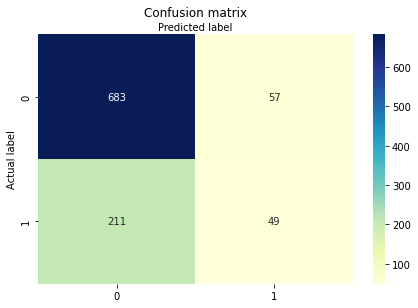

In [ ]:
###################################################################
# Random Forest - Tuned - depth=20, random state = 0, classweights75/25
###################################################################
X = train_data[feature_cols]
Y = train_labels
X_test = dev_data[feature_cols]

classWeights =  {0: .75,
                 1: .25}
                
rfc = RandomForestClassifier(max_depth = 20, random_state=0, class_weight=classWeights)

rfc.fit(X, Y)
Y_dev_RF_pred = rfc.predict(X_test)

# Score Ensemble against dev data
print("")
print("###################################################################")
print("Random Forest Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, Y_dev_RF_pred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(dev_labels, Y_dev_RF_pred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))
print("Accuracy:",metrics.accuracy_score(dev_labels, Y_dev_RF_pred))
print(classification_report(dev_labels, Y_dev_RF_pred))


###################################################################
Scikit Ensemble Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7605509355509356
Accuracy: 0.821
              precision    recall  f1-score   support

       False       0.87      0.89      0.88       740
        True       0.66      0.63      0.65       260

    accuracy                           0.82      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.82      0.82      0.82      1000



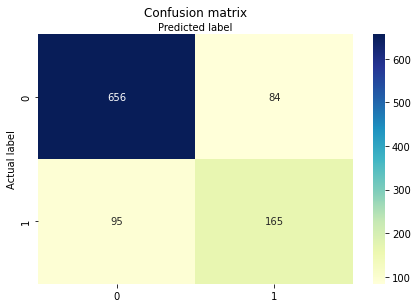

In [ ]:
###################################################################
# Scikit ENSEMBLE (soft voting), equal weights based on AUC scores
###################################################################
scores= [.76, .75]
models = list()
models.append(('lr', logreg))
models.append(('rfc', rfc))
#models.append(('svm', svm))

X = train_data[feature_cols]
Y = train_labels
X_test = dev_data[feature_cols]

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(X, Y)
ensemble_pred = ensemble.predict(X_test)

# Score Ensemble against dev data
print("")
print("###################################################################")
print("Scikit Ensemble Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(dev_labels, ensemble_pred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(dev_labels, ensemble_pred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(dev_labels, ensemble_pred))
print(classification_report(dev_labels, ensemble_pred))

In [ ]:
#print(df_test)

df_test['request_text_count'] = df_test['request_text_edit_aware'].str.count(' ') + 1
for col in df_test.columns:
    print(col)

test_feature_cols = ['request_text_count', 
                     #'number_of_upvotes_of_request_at_retrieval',
                     'requester_number_of_comments_at_request',
                     'requester_account_age_in_days_at_request',
                     'requester_days_since_first_post_on_raop_at_request',
                     'requester_number_of_comments_at_request',
                     'requester_number_of_comments_in_raop_at_request',
                     'requester_number_of_posts_on_raop_at_request', 
                    ]

test_pred = ensemble.predict(df_test[test_feature_cols])

giver_username_if_known
request_id
request_text_edit_aware
request_title
requester_account_age_in_days_at_request
requester_days_since_first_post_on_raop_at_request
requester_number_of_comments_at_request
requester_number_of_comments_in_raop_at_request
requester_number_of_posts_at_request
requester_number_of_posts_on_raop_at_request
requester_number_of_subreddits_at_request
requester_subreddits_at_request
requester_upvotes_minus_downvotes_at_request
requester_upvotes_plus_downvotes_at_request
requester_username
unix_timestamp_of_request
unix_timestamp_of_request_utc
request_text_count


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- requester_account_age_in_days_at_request
- requester_days_since_first_post_on_raop_at_request
- requester_number_of_comments_at_request
Feature names seen at fit time, yet now missing:
- number_of_upvotes_of_request_at_retrieval
- request_number_of_comments_at_retrieval
- requester_account_age_in_days_at_retrieval
- requester_days_since_first_post_on_raop_at_retrieval
- requester_number_of_comments_at_retrieval
- ...

  warnings.warn(message, FutureWarning)


ValueError: ignored